In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-08 22:46:16.346845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 22:46:16.907978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    



In [3]:



mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
# FEATURE_COLS = test_df.columns[1:-4].tolist()

selected_features_pickle_path = './data/selected_features_list.pickle'
with open(selected_features_pickle_path, 'rb') as f:
    FEATURE_COLS = pickle.load(f)

print(FEATURE_COLS)



['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg', 'SOIL_phh2o_100.200cm_mean_0.01_deg', 'SOIL_phh2o_15.30cm_mean_0.01_deg', 'SOIL_phh2o_30.60cm_mean_0.01_deg', 'SOIL_phh2o_5.15cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12'

In [4]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,0.521268,15.910891,3.160711,1.615603,41.319274,1843.646287
std,0.145251,7.863849,5.322841,0.662838,164.948299,3153.292771
min,0.006996,1.186970,0.002919,0.076517,0.000179,1.108830
25%,0.411105,10.759204,0.306121,1.176479,0.545185,256.789938
50%,0.507643,15.164677,0.697812,1.476696,2.420592,711.579570
75%,0.620997,19.620579,3.313238,1.911236,13.790889,2064.455660
max,0.958177,60.206352,33.275509,5.002875,2387.617647,31535.016150


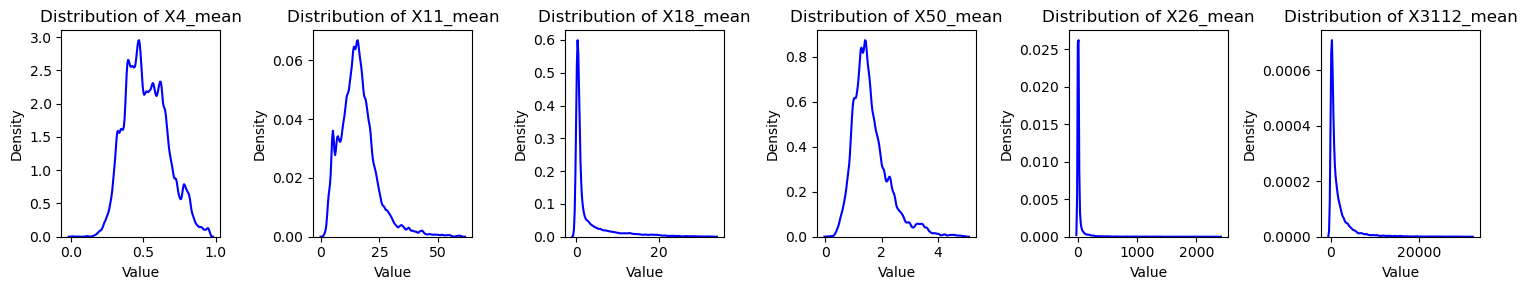

In [7]:
plot_data(train_df, mean_columns)

In [8]:
# train_df[mean_columns] = np.log10(train_df[mean_columns])

In [9]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,0.521268,15.910891,3.160711,1.615603,41.319274,1843.646287
std,0.145251,7.863849,5.322841,0.662838,164.948299,3153.292771
min,0.006996,1.186970,0.002919,0.076517,0.000179,1.108830
25%,0.411105,10.759204,0.306121,1.176479,0.545185,256.789938
50%,0.507643,15.164677,0.697812,1.476696,2.420592,711.579570
75%,0.620997,19.620579,3.313238,1.911236,13.790889,2064.455660
max,0.958177,60.206352,33.275509,5.002875,2387.617647,31535.016150


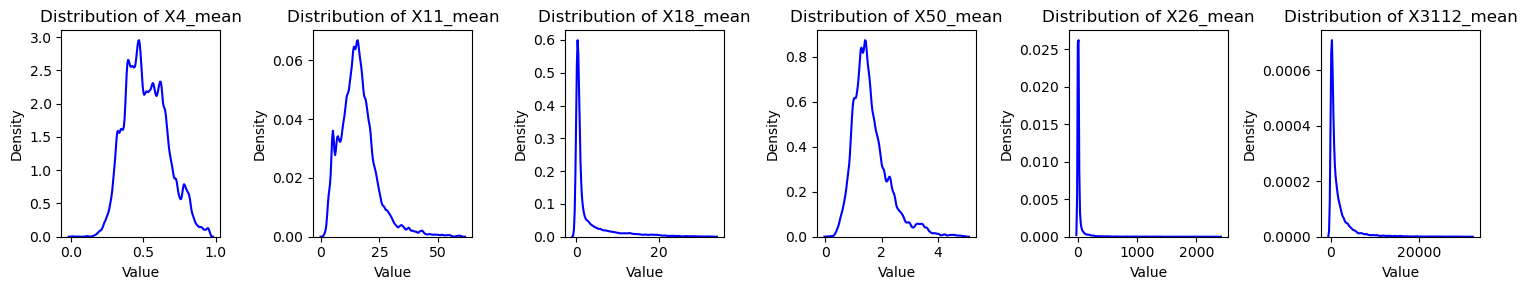

In [10]:
plot_data(train_df, mean_columns)

In [11]:
print(train_df['fold'].value_counts())

# scaler = StandardScaler() # TODO testaa robustscaler
scaler = RobustScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)




fold
2.0    10736
0.0    10736
3.0    10736
1.0    10736
4.0    10735
Name: count, dtype: int64
# Num Train: 42943 | Num Valid: 10736


/tmp/ipykernel_21184/2055694891.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_21184/2055694891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [12]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
# y_train = train_df[mean_columns].values
y_train = train_df[mean_columns]

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
# y_valid = valid_df[mean_columns].values
y_valid = valid_df[mean_columns]



In [13]:
print(X_train_tab.shape)

(42943, 81)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 


def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss


global current_delta
def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 2)
    max_img_units = 2000
    img_dense = image_features_input
    
    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_img = trial.suggest_categorical(f'Act_img', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_img = trial.suggest_float(f'Drop_img', 0.2, 0.7, step=0.1)
    batch_norm_img = trial.suggest_categorical(f'Img_BatchN', choices = [True, False])
    for i in range(img_num_layers):

        num_img_units = trial.suggest_int(f'Num_img_{i}', 128, max_img_units, log = True)        
        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img:
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)
        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 2)
    max_tab_units = 1000
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_tab = trial.suggest_categorical(f'Act_tab', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_tab = trial.suggest_float(f'Drop_tab', 0.2, 0.7, step = 0.1)
    batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN', choices = [True, False])
    for i in range(tab_num_layers):

        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 64, max_tab_units, log = True)    
        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab:
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 2)
    max_com_units = 3000
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'random_normal', 'random_uniform'])
    activation_common = trial.suggest_categorical(f'Act_con',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_common = trial.suggest_float(f'Drop_con', 0.2, 0.7, step = 0.1)
    batch_norm_common = trial.suggest_categorical(f'Com_BatchN', [True, False])
    for i in range(com_num_layers):
        
        num_common_units = trial.suggest_int(f'Num_con_{i}', 128, max_com_units, log = True)
        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common:
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='linear')(concatenated)  
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)
    
    
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad()
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta()
    else:
        optimizer = optimizers.Adamax()

    delta = trial.suggest_float('delta', 0.0, 2.5, step=0.1)
    global current_delta
    current_delta = delta

    model.compile(optimizer=optimizer, loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    # model.compile(optimizer=optimizers.Adam(), loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    # model.compile(optimizer= optimizers.Adam(), loss='mse', metrics=['mse','mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    y_train_transformed = y_train.copy()
    y_valid_transformed = y_valid.copy()


    log_base_options = {'none': None, 'log2': 2, 'log10': 10}
    log_transforms = {}
    for target in mean_columns:
        log_base = trial.suggest_categorical(f'log_base_{target}', list(log_base_options.keys()))
        log_transforms[target] = log_base_options[log_base]

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",            
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=0)


    callbacks = [
                 ReduceLROnPlateau('val_r2_score', patience=3, factor=0.7, mode = 'max'), 
                 TerminateOnNaN(),                
                 model_checkpoint_callback,
                 EarlyStopping(monitor='val_r2_score', patience=5, mode='max', verbose = 1)
                 ]
    
    for target, log_base in log_transforms.items():
        if log_base:
            y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
            y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)
        else:
            y_train_transformed[target] = y_train[target]
            y_valid_transformed[target] = y_valid[target]


    history = model.fit([X_train_feat, X_train_tab], y_train_transformed, validation_data=([X_valid_feat, X_valid_tab], y_valid_transformed), batch_size=512, epochs=50, callbacks=callbacks, verbose = 0)

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1

    model.load_weights(f'./data/{study_name}_search_model.h5')

    preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)    

    preds_transformed = preds.copy()
    for i, target in enumerate(mean_columns):
        log_base = log_transforms[target]
        if log_base is not None:
            preds_transformed[:, i] = np.power(log_base, preds[:, i])
            y_valid_transformed[target] = np.power(log_base, y_valid_transformed[target])

    r2_score_inv = r2_score(y_valid_transformed, preds)

    if trial.number > 0:
        if r2_score_inv > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {r2_score_inv:.5f}')
                    
            r2 = r2_score(y_valid_transformed, preds)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_transformed, preds)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_transformed, preds)
            huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_transformed, preds)
            print(f'Best epoch power errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            
            
            # model.load_weights(f'./data/{study_name}_search_model.h5')
            
            # preds = model.predict([X_valid_feat, X_valid_tab])
            # preds_2 = np.square(preds)
            # # y_valid_2 = np.square(y_valid)
            # preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)    
            
            # r2 = r2_score(y_valid_transformed, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw errors : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds_inv = scaler_minmax.inverse_transform(preds)
            # y_valid_inv = scaler_minmax.inverse_transform(y_valid)
            # r2 = r2_score(y_valid_inv, preds_inv)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid_inv, preds_inv)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid_inv, preds_inv)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # print(f'Best epoch minmax.inv R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # r2 = r2_score(y_valid, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid, preds)
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./data/{study_name}_best_val_{r2_score_inv:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')    
            model.save(best_filename)

            log_transforms = {'log_base': log_base}
            print(f'Saving log transforms to {study_name}_{r2_score_inv}_best_log_transforms.pickle')
            with open(f'./data/{study_name}_{r2_score_inv}_best_log_transforms.pickle', 'wb') as f:
                pickle.dump(log_transforms, f)



            print("*" * 50)

    if os.path.exists(f'./data/{study_name}_search_model.h5'):
        os.remove(f'./data/{study_name}_search_model.h5')

    tf.keras.backend.clear_session()
    gc.collect()
            
    return r2_score_inv


study_name = '408_logselect_harotesti_fold_3'
num_random_trials = 10
num_tpe_trial = 3
search_time_max = 3600 * 18

study = optuna.create_study(direction='maximize',                            
                            study_name=study_name,
                            storage=f'sqlite:///409_logselect_huber.db',
                            load_if_exists=True                            
                            )

search_time_taken = 0
search_start = time.time()
round = 0

while search_time_taken < search_time_max:

    round_start = time.time()

    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) 
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start))}')
    print(f'Starting TPE {num_tpe_trial} trials...')    
    study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_tpe_trial)
    print(f'Time taken for one trial: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')    
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')
    
    search_time_taken = time.time() - search_start
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')




[I 2024-04-08 22:51:31,919] Using an existing study with name '408_logselect_yotesti_viimeinen_fold_3' instead of creating a new one.
/tmp/ipykernel_21184/385463181.py:270: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)


Starting study with 5 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------


[I 2024-04-08 22:51:42,614] Trial 22 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': False, 'Num_img_0': 328, 'Num_img_1': 156, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 195, 'Num_tab_1': 138, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': True, 'Num_con_0': 141, 'Num_con_1': 133, 'optimizer': 'Adadelta', 'delta': 1.3, 'log_base_X4_mean': 'log10', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'log2', 'log_base_X50_mean': 'none', 'log_base_X26_mean': 'none', 'log_base_X3112_mean': 'none'}. Best is trial 6 with value: 0.08283551713873476.
[I 2024-04-08 22:51:51,308] Trial 23 finished with value: 0.028413434183883462 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 654, 'Num_img_1': 1

**************************************************
Old best R2 : 0.08284
New best R2 : 0.08622
Best epoch power errors R2 : 0.08622, MSE : 1307335.87500, MAE : 223.18040, huber_loss : 267.13419
Best epoch : 5
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.08622_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.0862212579684566_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:52:13,055] Trial 25 finished with value: 0.0862212579684566 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': True, 'Num_img_0': 550, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 918, 'Num_tab_1': 268, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': False, 'Num_con_0': 560, 'optimizer': 'rmsprop', 'delta': 1.2000000000000002, 'log_base_X4_mean': 'none', 'log_base_X11_mean': 'log2', 'log_base_X18_mean': 'log10', 'log_base_X50_mean': 'log2', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'none'}. Best is trial 25 with value: 0.0862212579684566.
[I 2024-04-08 22:52:23,279] Trial 26 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': True, 'Num_img_0': 139, 'Num_img_1': 139, 'Tabular layers'

Time taken for random trials: 0:00:51.355174
Starting TPE 10 trials...
**************************************************
Old best R2 : 0.08622
New best R2 : 0.09155
Best epoch power errors R2 : 0.09155, MSE : 2302637.25000, MAE : 316.95407, huber_loss : 663.73511
Best epoch : 4
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.09155_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.09155093372861994_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:52:37,727] Trial 27 finished with value: 0.09155093372861994 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': True, 'Num_img_0': 190, 'Num_img_1': 182, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 988, 'Num_tab_1': 684, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': False, 'Num_con_0': 460, 'optimizer': 'rmsprop', 'delta': 2.1, 'log_base_X4_mean': 'log2', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'none', 'log_base_X3112_mean': 'log10'}. Best is trial 27 with value: 0.09155093372861994.
[I 2024-04-08 22:52:48,831] Trial 28 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': True, 'Num_img_0': 464, 'Tabular layers': 2, 'Tab

**************************************************
Old best R2 : 0.09155
New best R2 : 0.10067
Best epoch power errors R2 : 0.10067, MSE : 2302707.75000, MAE : 317.17926, huber_loss : 632.65796
Best epoch : 4
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.10067_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.10066654409000274_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:53:20,918] Trial 30 finished with value: 0.10066654409000274 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': True, 'Num_img_0': 200, 'Num_img_1': 190, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 929, 'Num_tab_1': 884, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': True, 'Num_con_0': 342, 'optimizer': 'Nadam', 'delta': 2.0, 'log_base_X4_mean': 'log2', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'log10'}. Best is trial 30 with value: 0.10066654409000274.


**************************************************
Old best R2 : 0.10067
New best R2 : 0.11321
Best epoch power errors R2 : 0.11321, MSE : 2302784.50000, MAE : 317.14072, huber_loss : 632.59741
Best epoch : 5
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.11321_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.11321263341845413_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:53:38,936] Trial 31 finished with value: 0.11321263341845413 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': True, 'Num_img_0': 257, 'Num_img_1': 213, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 967, 'Num_tab_1': 880, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 158, 'optimizer': 'Nadam', 'delta': 2.0, 'log_base_X4_mean': 'log2', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'log10'}. Best is trial 31 with value: 0.11321263341845413.
[I 2024-04-08 22:53:56,341] Trial 32 finished with value: 0.07133674658594034 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.60000000000000

**************************************************
Old best R2 : 0.11321
New best R2 : 0.12113
Best epoch power errors R2 : 0.12113, MSE : 2302772.25000, MAE : 316.91977, huber_loss : 284.90796
Best epoch : 4
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.12113_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.12112661241237309_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:55:04,734] Trial 36 finished with value: 0.12112661241237309 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': True, 'Num_img_0': 328, 'Num_img_1': 272, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 535, 'Num_tab_1': 400, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': True, 'Num_con_0': 167, 'optimizer': 'Nadam', 'delta': 0.9, 'log_base_X4_mean': 'none', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'log10'}. Best is trial 36 with value: 0.12112661241237309.
/tmp/ipykernel_21184/385463181.py:270: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_

Time taken for one trial: 0:00:14.187313
Time this round: 0:03:32.809756
Starting study with 5 random trials, round 1
Search time so far taken : 0:03:32.809917
--------------------------------------------------


[I 2024-04-08 22:55:16,271] Trial 37 finished with value: 0.07184883515394556 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 1095, 'Num_img_1': 149, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': True, 'Num_tab_0': 461, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 1234, 'Num_con_1': 429, 'optimizer': 'adamax', 'delta': 1.8, 'log_base_X4_mean': 'log10', 'log_base_X11_mean': 'log10', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'none', 'log_base_X26_mean': 'log10', 'log_base_X3112_mean': 'log10'}. Best is trial 36 with value: 0.12112661241237309.
[I 2024-04-08 22:55:31,239] Trial 38 finished with value: 0.0027014145284441904 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': True, 'Num_img

Time taken for random trials: 0:01:01.759010
Starting TPE 10 trials...


[I 2024-04-08 22:56:23,519] Trial 42 finished with value: 0.10178325807331955 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': True, 'Num_img_0': 160, 'Num_img_1': 160, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': True, 'Num_tab_0': 473, 'Num_tab_1': 380, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 211, 'optimizer': 'Nadam', 'delta': 0.8, 'log_base_X4_mean': 'log10', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'log10'}. Best is trial 36 with value: 0.12112661241237309.
[I 2024-04-08 22:56:41,232] Trial 43 finished with value: 0.09485836436128288 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 

**************************************************
Old best R2 : 0.12113
New best R2 : 0.14830
Best epoch power errors R2 : 0.14830, MSE : 2302688.25000, MAE : 316.83472, huber_loss : 221.58530
Best epoch : 5
Saving model to ./data/408_logselect_yotesti_viimeinen_fold_3_best_val_0.14830_model.h5
Saving log transforms to 408_logselect_yotesti_viimeinen_fold_3_0.14829778209504832_best_log_transforms.pickle
**************************************************


[I 2024-04-08 22:56:56,318] Trial 44 finished with value: 0.14829778209504832 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': False, 'Num_img_0': 291, 'Num_img_1': 237, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': True, 'Num_tab_0': 601, 'Num_tab_1': 458, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 145, 'optimizer': 'Nadam', 'delta': 0.7000000000000001, 'log_base_X4_mean': 'none', 'log_base_X11_mean': 'none', 'log_base_X18_mean': 'none', 'log_base_X50_mean': 'log10', 'log_base_X26_mean': 'log2', 'log_base_X3112_mean': 'log10'}. Best is trial 44 with value: 0.14829778209504832.
[I 2024-04-08 22:57:10,989] Trial 45 finished with value: 0.08158148894252765 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': False, 

In [ ]:
print(test_df.columns)
print(FEATURE_COLS)
print(len(FEATURE_COLS))

print(train_df.columns)
print(train_df.shape)

In [ ]:

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 

def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss




custom_objects = {"r2_score": r2_score, "huber_loss": huber_loss_wrapper(1.5)}


with open('./data/scaler_tabufeatures_train.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('./data/scaler_minmax.pickle', 'rb') as f:
    scaler_minmax = pickle.load(f)


best_model_name = './data/407_kuten_artikkeli_openheimer_rmsprop_r2pruning_fold_3_best_val_0.27421_model.h5'

best_model = tf.keras.models.load_model(f'{best_model_name}', custom_objects=custom_objects)

test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS].values)


 
submission_df = test_df[['id']].copy()

X_test_tab = test_df[FEATURE_COLS].values
X_test_feat = np.stack(test_df['features'].values) 

predictions = best_model.predict([X_test_feat, X_test_tab])
predictions = np.power(10, predictions)

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions

print(submission_df.head())
print(submission_df.shape)
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)
submission_df.head()




